# Milestone 2 - Independent Project

## Author - Rodolfo Lerma


# Problem

Is there a feature or set of features that would yield to a higher home price for the King County Region?

# Abstract

This analysis is divided in the following way:

**Data Cleaning**

**Analysis**

- *Functions for analysis*


- *Exploration of dataset*


- *Likely distribution for `price` & `sqft_living`*
    - `price`
    - `sqft_living`
    
    
- *Basic statistics by both Classic boostrap & Bayesian Model* 
    - Creating Bins to split the data and look at the distribution
    - Boostraping
    - Bayes Model


- *Confidence intervals and hypothesis test to determine differences*
    - `Condition`
        - Boostrap
        - Bayes Model
    - `Grade`
        - Boostrap
        - Bayes Model
    - `Bedrooms`
        - Boostrap
        - Bayes Model
    - `Bathrooms`
        - Boostrap
        - Bayes Model


- *Summary of Analysis (Conclusions)*

**Since in previous analysis (Milestone 1) it was already presented the *first look to the data* an some reasoning on why the data was filtered in certain way, in this section of the analysis it would be assumed as already covered and understood.**

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import scipy.stats as ss
from statistics import mean
import statsmodels.stats.weightstats as ws 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import scale
from scipy.stats import kstest
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
#Load File
filename = 'kc_house_data.csv'
house_df = pd.read_csv(filename)

# Data cleaning:

In [3]:
#Removing outliers based on Price:
LimitHi = np.mean(house_df['price']) + 1*np.std(house_df['price']) #Higher Limit for each of the numeric attributes
LimitLo = np.mean(house_df['price']) - 1*np.std(house_df['price']) #Lower Limit for each of the numeric attributes
FlagBad = (house_df['price'] < LimitLo) | (house_df['price'] > LimitHi) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood]

#Some cleaning of the data (outliers) will be removed since we are interested in the typical market for the region.
FlagBad = (house_df['bedrooms'] > 8) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood] 

FlagBad = (house_df['bathrooms'] > 6) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood] 

FlagBad = (house_df['sqft_lot'] > 50000) #Boolean for values outside limits
FlagGood = ~FlagBad #Complement
house_df = house_df.loc[FlagGood] 

In [4]:
#Transforming the variable date into DateTime Variable
house_df.loc[:, 'date'] = pd.to_datetime(house_df.loc[:, 'date'])
house_df.set_index('date', inplace = True)

In [5]:
#Column price from str to numeric (int64)
house_df['price'] = pd.to_numeric(house_df['price'])

#Creating a variable called `price_log`
house_df['price_log'] = np.log(house_df['price'])

#Column price from str to numeric (int64)
house_df['sqft_living'] = pd.to_numeric(house_df['sqft_living'])

#Creating a variable called `price_log`
house_df['sqft_living_log'] = np.log(house_df['sqft_living'])

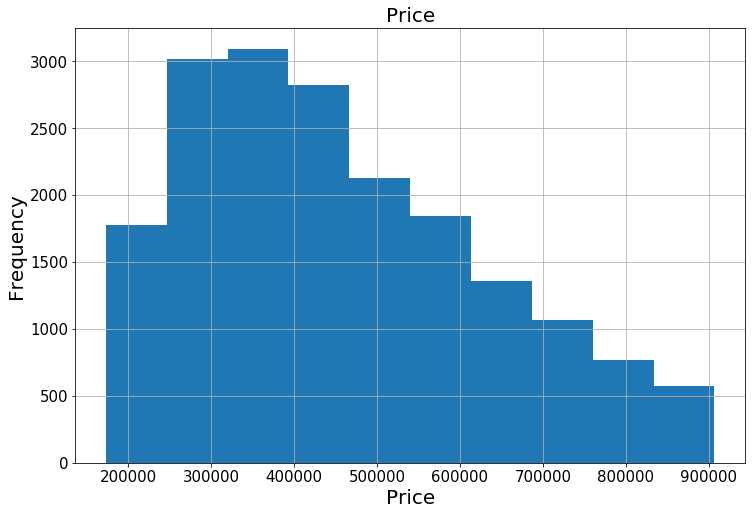

In [6]:
house_df['price'].hist(figsize = (12,8))
plt.xlabel('Price', fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
plt.title('Price', fontsize = 20)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.grid(True)
plt.show()

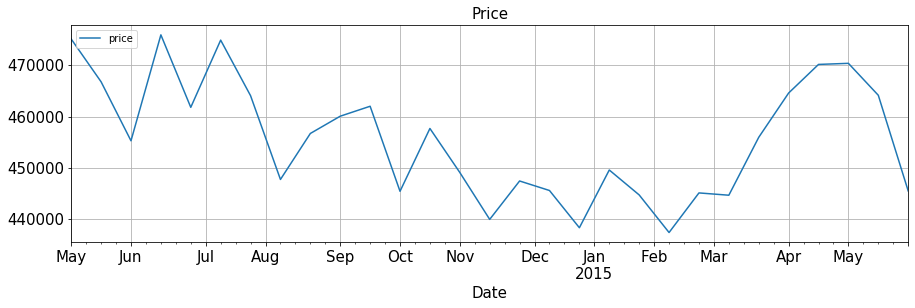

In [7]:
#Time series plot for Price
#To minimize the noise each data point seen here is the mean of a 2 Weeks sample
house_df[["price"]].resample("2W").mean().plot(figsize=(15,4))
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.xlabel('Date', fontsize = 15)
plt.title('Price',fontsize=15)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)

# Analysis

## Functions for anaysis

In [8]:
#Kernel Density Estimation Plots (to take a look at the Distribution for each of the variables)
def kde_plot(a):
    fig = plt.figure(figsize=(6,4)) # Define plot area
    ax = fig.gca() # Define axis 
    sns.set_style("whitegrid")
    sns.kdeplot(house_df[a], ax = ax, label = a)
    ax.set_title('Distribution of ' + a, fontsize = 15) # Give the plot a main title
    ax.set_xlabel(a, fontsize = 15) # Set text for the x axis
    ax.set_ylabel('Density', fontsize = 15)# Set text for y axis
    ax.legend(loc='upper right', fontsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.grid(True)    

def qq_plot(vec1, vec2):
    plt.figure(figsize=(12, 12)).gca() # define axis
    ax1 = plt.subplot(221) ## setup the left subplot
    ss.probplot(vec1, plot = ax1) ## Plot the left subplot
    ax1 = plt.subplot(222) ## Set up the right subplot
    ss.probplot(vec2, plot = ax1) ## Plot the right subplot

def plot_cums(dist1, dist2):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)
    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p, color = 'blue')
    plt.scatter(data_sorted, p, color = 'red')
    # sort the seond data sample:
    data_sorted = np.sort(dist2)
    # And the second plot
    plt.plot(data_sorted, p, color = 'orange')
    plt.scatter(data_sorted, p, color = 'green')

def ks_test_norm(dat, dist = 'norm'):
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))
 
def ks_test_lognorm(data, dist = 'lognorm'):
    count, bins, ignored = plt.hist(data, 50, normed=True, align='mid')
    fig = plt.figure(figsize=(6,4))
    ax = fig.gca() # Define axis
    sns.kdeplot(data, ax = ax)
    params = stats.lognorm.fit(count)
    ks_statisic, pvalue = kstest(count, dist, params)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))
    
def plot_dists(a, b, nbins, a_label='pop_A', b_label='pop_B'):
    # Create a single sequence of bins to be shared across both
    # distribution plots for visualization consistency.
    combined = pd.concat([a, b])
    breaks = np.linspace(
        combined.min(), 
        combined.max(), 
        num=nbins+1)
    plt.subplot(2, 1, 1)
    plt.hist(a,  bins=breaks, label=a_label, alpha=0.5)
    plt.axvline(a.mean(), linewidth=4)
    plt.legend() 
    plt.title(a_label) 
    plt.subplot(2, 1, 2)
    plt.hist(b,  bins=breaks, label=b_label, alpha=0.5)
    plt.axvline(b.mean(), linewidth=4)
    plt.legend() 
    plt.title(b_label) 
    plt.tight_layout()

def kde_plots(a,b,c,d,e,f,g):
    fig = plt.figure(figsize=(8,6)) # Define plot area
    ax = fig.gca() # Define axis 
    sns.set_style("whitegrid")
    sns.kdeplot(a, ax = ax, label = d)
    sns.kdeplot(b, ax = ax, label = e)
    sns.kdeplot(c, ax = ax, label = f)
    ax.set_title('KDE plot of auto price ' + g, fontsize = 20) # Give the plot a main title
    ax.set_xlabel('Price', fontsize = 15) # Set text for the x axis
    ax.set_ylabel('Density', fontsize = 15)# Set text for y axis
    ax.legend(loc='upper right', fontsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.grid(True)
    
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

def comp_like(p, x): 
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()

def ks_test_lognorm(data, dist = 'lognorm'):
    from scipy.stats import kstest
    import scipy.stats as stats
    count, bins, ignored = plt.hist(data, 50, normed=True, align='mid')
    fig = plt.figure(figsize=(6,4))
    ax = fig.gca() # Define axis
    sns.kdeplot(data, ax = ax)
    params = stats.lognorm.fit(count)
    ks_statisic, pvalue = kstest(count, dist, params)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))
    
def t_test(a, b, alpha, alternative='two-sided'):
    diff = a.mean() - b.mean()
    res = ss.ttest_ind(a, b, equal_var=False)  
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()
    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)

#Kernel Density Estimation Plots (to take a look at the Distribution for each of the variables)
def kde_plot2(a,b,c,d,e):
    fig = plt.figure(figsize=(6,4)) # Define plot area
    ax = fig.gca() # Define axis 
    sns.set_style("whitegrid")
    sns.kdeplot(a, ax = ax, label = c)
    sns.kdeplot(b, ax = ax, label = d)
    ax.set_title('KDE plot of auto price ' + e, fontsize = 15) # Give the plot a main title
    ax.set_xlabel('Price', fontsize = 15) # Set text for the x axis
    ax.set_ylabel('Density', fontsize = 15)# Set text for y axis
    ax.legend(loc='upper left', fontsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.grid(True)
    
def plot_ci(p, post, num_samples, lower_q, upper_q,x,y):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles. Assumes a pretty symmetrial distribution
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval, fontsize = 15)
    plt.plot(p, post, color='blue')
    plt.xlabel('Parameter value', fontsize = 15)
    plt.ylabel('Density', fontsize = 15)
    plt.xlim(x,y)
    plt.axvline(x=ci[0], color='red')
    plt.axvline(x=ci[1], color='red')
    print('The %.3f credible interval is %.3f to %.3f' 
          % (interval, ci[0], ci[1]))

## Exploration of dataset

In the previous analysis (Milestone 01) it was shown that some of the variables (attributes) in the data set do not add value to predict the `price` of a house. For tha reason those columns were removed from this analysis and are not going to be covered in here.

The variables that will be explore are:

- `price`
- `sqft_living`
- `bedrooms`
- `bathrooms`
- `floors`
- `view`
- `condition`
- `grade`

For simplicity in this analysis categorical variables or variables were values are discrete will be bin into either 2 or 3 categories as needed.

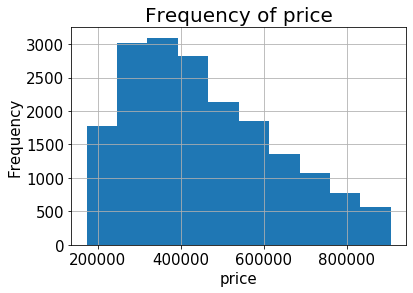

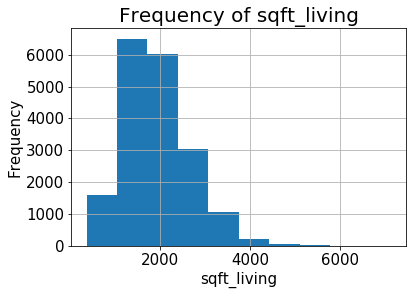

In [9]:
numerical = ['price','sqft_living']
categorical = ['bedrooms','bathrooms','floors','view','condition','grade']

for i in numerical:
    house_df[i].hist(figsize = (6,4))
    plt.xlabel(i, fontsize = 15)
    plt.ylabel('Frequency',fontsize = 15)
    plt.title('Frequency of ' + i, fontsize = 20)
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)
    plt.grid(True)
    plt.show()

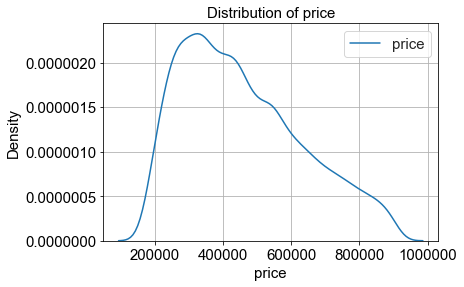

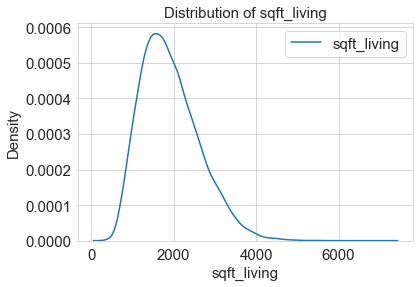

In [10]:
for i in numerical:
    kde_plot(i)

## Likely distribution for `price` & `sqft_living`

It seems that both variables have a Log-Normal Distribution behaivor as seen in the plot below. But for simplistic reasons both the log of each variable will be treated as normal distributed.

We will look at 2 variables to determine the kind of distribution we might have:

- `price`
- `sqft_living`

Text(0.5, 1.0, 'Density of std Log-Normal')

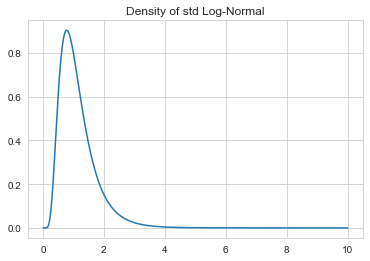

In [11]:
import scipy
x = np.linspace(.01, 10, num=10000)
log_normal_pdf = scipy.stats.lognorm.pdf(x, 0.5)
plt.plot(x, log_normal_pdf)
plt.title('Density of std Log-Normal')

The figure above ilustrates the shape of a classic lognorm distribution.

Text(0.5, 1.0, 'Density of std Log-Normal')

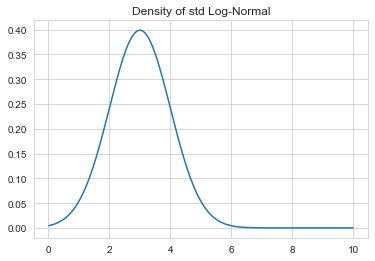

In [12]:
import scipy
x = np.linspace(.01, 10, num=10000)
log_normal_pdf = scipy.stats.norm.pdf(x,3)
plt.plot(x, log_normal_pdf)
plt.title('Density of std Log-Normal')

The figure above ilustrates the shape of a classic norm distribution.

### `price`

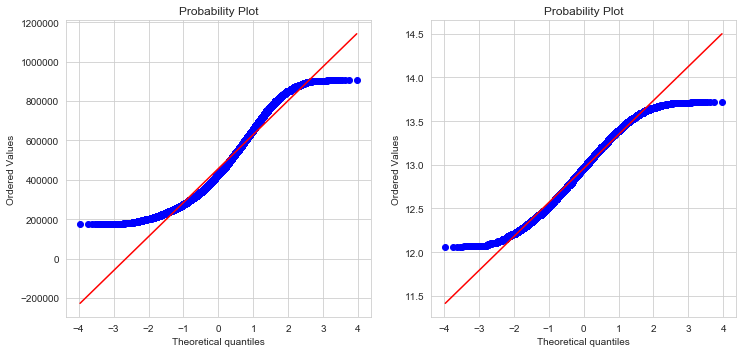

In [13]:
qq_plot(house_df['price'], house_df['price_log'])  

In [14]:
#Normalizing each of the price variables so it is possible to see both with same X axis and compare shapes
norm1_s = scale(house_df['price'])
norm2_s = scale(house_df['price_log'])

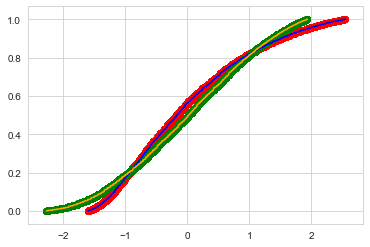

In [15]:
plot_cums(norm1_s, norm2_s) 

In [16]:
ks_test_norm(norm1_s)

KS-statistic = 0.07474562046835531
P-value = 5.3033789626588816e-90


In [17]:
ks_test_norm(norm2_s)

KS-statistic = 0.03855961738398761
P-value = 2.8975895289541807e-24


Based on the **KS-statistic** and the **p-value** on the section above it is possible to see that it seems that the `price` & `price_log` are not quite well represented by a normal distribution. Or another way to see it is:
The K-S statistic is quite large and the p-value is pretty small. The chance is high that we can reject the null hypothesis since the probability that the difference arises by chance alone is high. Therefore we reject the idea that the distribution for our data is **norm**. (strictly speaking)

KS-statistic = 0.09214522682880083
P-value = 0.7895849461495527


C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:101: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


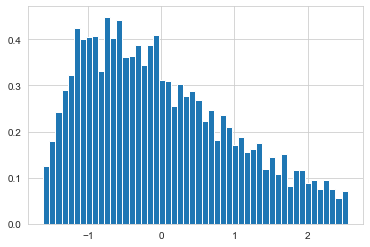

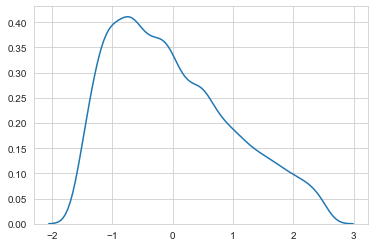

In [18]:
ks_test_lognorm(norm1_s)

The K-S statistic is quite small and the p-value is large. The chance is high that we cannot reject the null hypothesis since the probability that the difference arises by chance alone is high. Therefore we cannot reject the idea that the distribution for our data is **log_norm**.

In other words as expected (as for price variables) the distribution for `price` is a **log_norm** distribution.

### `sqft_living`

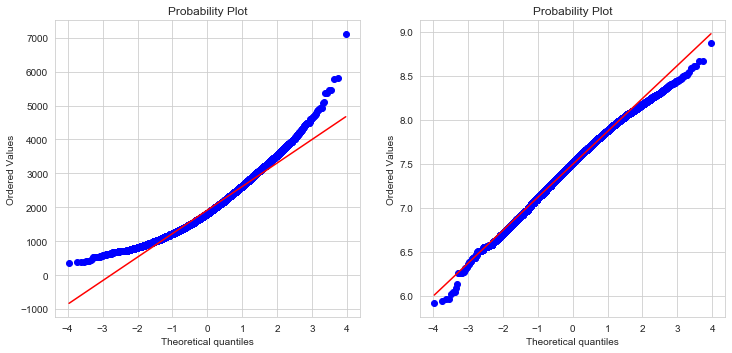

In [19]:
qq_plot(house_df['sqft_living'], house_df['sqft_living_log'])  

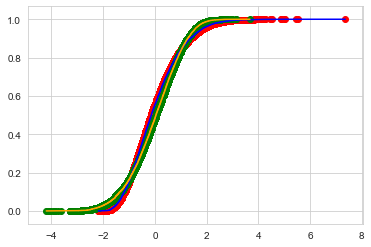

In [20]:
norm3_s = scale(house_df['sqft_living'])
norm4_s = scale(house_df['sqft_living_log'])
plot_cums(norm3_s, norm4_s) 

In [21]:
ks_test_norm(norm3_s)

KS-statistic = 0.05919946699287387
P-value = 1.2916786874370949e-56


In [22]:
ks_test_norm(norm4_s)

KS-statistic = 0.024492642997327008
P-value = 4.81759720078099e-10


Based on the **KS-statistic** and the **p-value** on the section above it is possible to see that `sqft_living` & `sqft_living_log` do not quite follow a normal distribution. Or another way to see it is:
The K-S statistic is quite large and the p-value is pretty small. The chance is high that we can reject the null hypothesis since the probability that the difference arises by chance alone is high. Therefore we reject the idea that the distribution for our data is **norm**. (strictly speaking)

C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:101: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


KS-statistic = 0.4699085609317176
P-value = 1.1974773971205565e-10


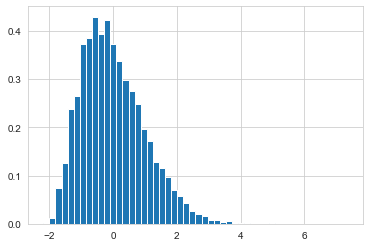

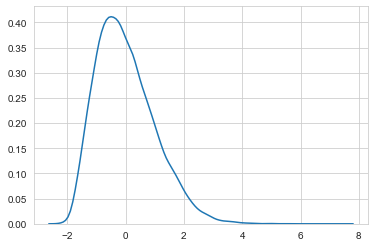

In [23]:
ks_test_lognorm(norm3_s)

In this case, the K-S statistic is large and the p-value quite small. We can reject the null hypothesis that these distributions are the same, and the chance of this difference of arising from random variation alone is quite small.

Therefore the `sqft_living` variable does not seem to follow neither a normal nor a log-normal distribution.

But since it seems to be closer to a normal distribution in later references normal distribution will be assumed for this variable.

## Basic statistics by both Classic boostrap & Bayesian Model

- For this point forward only the `price_log` variable will be analyzed since that is the one of most interest for the costumer.


- Some variables are going to be divided (bin) into small groups to be able to compared distributions:
   - `condition`
   - `grade`
   - `bedrooms`
   - `bathrooms`
  
 
 - In the previous Milestone (01) we saw that the following 2 factors do not contribute much to determine the price of a house, therefore are not going to be explored in this analysis:
  - `view`
  - `floors`

### Creating Bins to split the data and look at the distribution

The bins sizes were determined by the previous analysis (Milestone 01).

In [24]:
categorical = ['bedrooms','bathrooms','floors','view','condition','grade']
#first we need to ensure the variables are numeric
for i in categorical:
    house_df.loc[:, i] = house_df[i].astype(float)

In [25]:
#Creating bin variables to split the distribution
house_df['condition_binned'] = pd.cut(x=house_df['condition'], bins=[0,3,6], labels = [0, 1])
house_df['grade_binned'] = pd.cut(x=house_df['grade'], bins=[0,6,13], labels = [0, 1])
house_df['bedrooms_binned'] = pd.cut(x=house_df['bedrooms'], bins=[0,3,9], labels = [0, 1])
house_df['bathrooms_binned'] = pd.cut(x=house_df['bathrooms'], bins=[0,2,4,7], labels = [0, 1, 2])

#Splitting the data into the 2 categories inside the chosen variable
condition_low = house_df[house_df['condition_binned'] == 0]
condition_high = house_df[house_df['condition_binned'] == 1]

grade_low = house_df[house_df['grade_binned'] == 0]
grade_high = house_df[house_df['grade_binned'] == 1]

bedrooms_low = house_df[house_df['bedrooms_binned'] == 0]
bedrooms_high = house_df[house_df['bedrooms_binned'] == 1]

bathrooms_low = house_df[house_df['bathrooms_binned'] == 0]
bathrooms_mid = house_df[house_df['bathrooms_binned'] == 1]
bathrooms_high = house_df[house_df['bathrooms_binned'] == 2]

### Boostraping each variable

In [26]:
#Boostraping the mean for each of the 2 samples (Gas Vs Diesel)
n_replicas = 1000

###############################
con_low_b = pd.Series([
    condition_low.sample(frac=1, replace=True).price_log.mean()
    for i in range(n_replicas)])

con_high_b = pd.Series([
        condition_high.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])
###############################
gr_low_b = pd.Series([
        grade_low.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])

gr_high_b = pd.Series([
        grade_high.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])
###############################
bed_low_b = pd.Series([
        bedrooms_low.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])

bed_high_b = pd.Series([
        bedrooms_high.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])
###############################
bath_low_b = pd.Series([
        bathrooms_low.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])

bath_mid_b = pd.Series([
        bathrooms_mid.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])

bath_high_b = pd.Series([
        bathrooms_high.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])
###############################

Summary statistics from the Boostrap method

In [27]:
summary_con_low = con_low_b.describe()
summary_con_high = con_low_b.describe()
###############################
summary_gr_low = gr_low_b.describe()
summary_gr_high = gr_high_b.describe()
###############################
summary_bed_low = bed_low_b.describe()
summary_bed_high = bed_high_b.describe()
###############################
summary_bath_low = bath_low_b.describe()
summary_bath_mid= bath_mid_b.describe()
summary_bath_high = bath_high_b.describe()
###############################

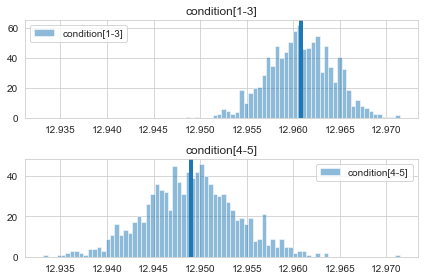

In [28]:
plot_dists(con_low_b, con_high_b, 
           nbins=80, a_label='condition[1-3]', b_label='condition[4-5]')

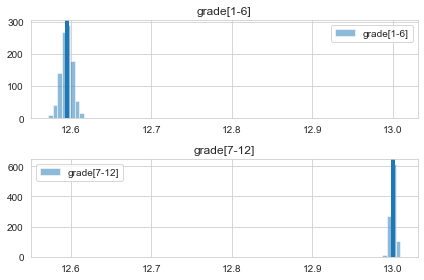

In [29]:
plot_dists(gr_low_b, gr_high_b, 
           nbins=80, a_label='grade[1-6]', b_label='grade[7-12]')

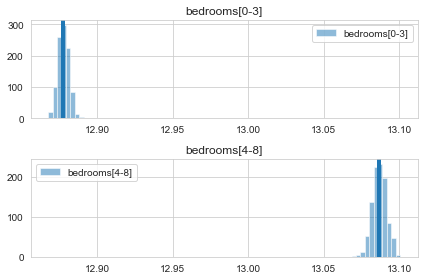

In [30]:
plot_dists(bed_low_b, bed_high_b, 
           nbins=80, a_label='bedrooms[0-3]', b_label='bedrooms[4-8]')

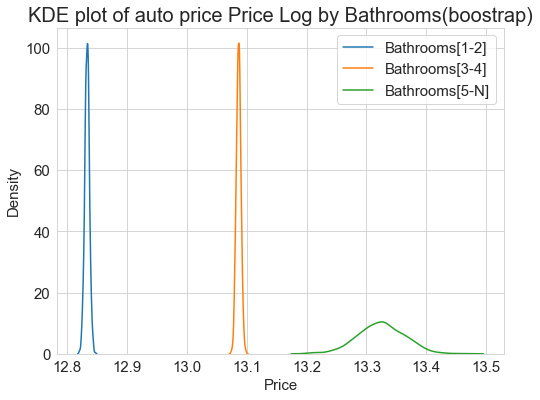

In [31]:
kde_plots(bath_low_b,bath_mid_b,bath_high_b,"Bathrooms[1-2]","Bathrooms[3-4]","Bathrooms[5-N]","Price Log by Bathrooms(boostrap)")

In [32]:
print('Condition Low Boostrap')
print(summary_con_low)
print('******************')
print('Condition High Boostrap')
print(summary_con_high)
print('******************')
print('Grade Low Boostrap')
print(summary_gr_low)
print('******************')
print('Grade High Boostrap')
print(summary_gr_high)
print('******************')
print('Bedrooms Low Boostrap')
print(summary_bed_low)
print('******************')
print('Bedrooms High Boostrap')
print(summary_bed_high)
print('******************')
print('Bathrooms High Boostrap')
print(summary_bath_low)
print('******************')
print('Bathroom Mid Boostrap')
print(summary_bath_mid)
print('******************')
print('Bathroom High Boostrap')
print(summary_bath_high)

Condition Low Boostrap
count    1000.000000
mean       12.960799
std         0.003493
min        12.948499
25%        12.958373
50%        12.960764
75%        12.963278
max        12.971444
dtype: float64
******************
Condition High Boostrap
count    1000.000000
mean       12.960799
std         0.003493
min        12.948499
25%        12.958373
50%        12.960764
75%        12.963278
max        12.971444
dtype: float64
******************
Grade Low Boostrap
count    1000.000000
mean       12.594350
std         0.007180
min        12.571805
25%        12.589414
50%        12.594354
75%        12.599141
max        12.615505
dtype: float64
******************
Grade High Boostrap
count    1000.000000
mean       13.000007
std         0.002926
min        12.989718
25%        12.998008
50%        12.999969
75%        13.001954
max        13.009224
dtype: float64
******************
Bedrooms Low Boostrap
count    1000.000000
mean       12.877592
std         0.003494
min        12.867600


### Bayes Model

#### Shape of Log Normal Likelihood

Text(0, 0.5, 'Likelihood')

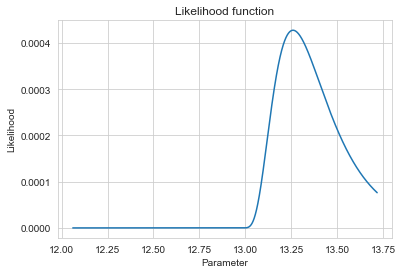

In [33]:
N = 10000
p = np.linspace(min(house_df.price_log),max(house_df.price_log), num=N)

pp_lognorm = scipy.stats.lognorm.pdf(p, s =0.5, loc=condition_low.price_log.mean(), scale= np.std(condition_low.price_log))
l = pp_lognorm / pp_lognorm.sum() # normalize

plt.plot(p, l)
plt.title('Likelihood function')
plt.xlabel('Parameter')
plt.ylabel('Likelihood')

As mentioned before this is the shape we would be expecting for a **lognorm** distribution with the characteristics of the data we have.

#### Shape of Normal Likelihood

Text(0, 0.5, 'Likelihood')

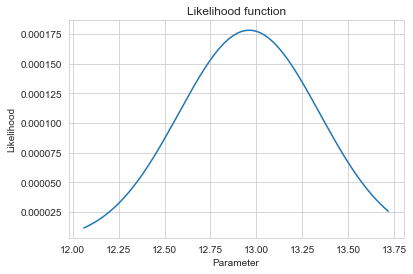

In [34]:
pp_norm = scipy.stats.norm.pdf(p, loc=condition_low.price_log.mean(), scale= np.std(condition_low.price_log))
ll = pp_norm / pp_norm.sum() # normalize

plt.plot(p, ll)
plt.title('Likelihood function')
plt.xlabel('Parameter')
plt.ylabel('Likelihood')

As mentioned before this is the shape we would be expecting for a **norm** distribution with the characteristics of the data we have.

Mean = 12.961, Standard deviation = 0.384


<function matplotlib.pyplot.show(*args, **kw)>

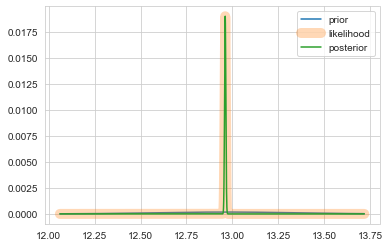

In [35]:
p = np.linspace(min(house_df.price_log),max(house_df.price_log), num=N)

#prior as a log norm distribution
#pp_con_low = scipy.stats.lognorm.pdf(p, s =1, loc=condition_low.price_log.mean(), scale= np.std(condition_low.price_log))
pp_con_low = scipy.stats.norm.pdf(p, loc=condition_low.price_log.mean(), scale= np.std(condition_low.price_log))
pp_con_low = pp_con_low / pp_con_low.sum() # normalize

like_con_low = comp_like(p, condition_low.price_log)
post_con_low = posterior(pp_con_low, like_con_low)

plt.plot(p, pp_con_low, label='prior')
plt.plot(p, like_con_low, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_con_low, label='posterior')
plt.legend()
plt.show

Mean = 12.949, Standard deviation = 0.410


<function matplotlib.pyplot.show(*args, **kw)>

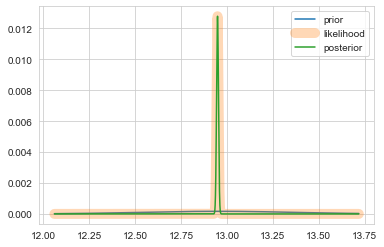

In [36]:
#pp_con_high = scipy.stats.lognorm.pdf(p,s=.95, loc=condition_high.price_log.mean(), scale= np.std(condition_high.price_log))
pp_con_high = scipy.stats.norm.pdf(p, loc=condition_high.price_log.mean(), scale= np.std(condition_high.price_log))
pp_con_high = pp_con_high / pp_con_high.sum() # normalize

like_con_high = comp_like(p, condition_high.price_log)
post_con_high = posterior(pp_con_high, like_con_high)

plt.plot(p, pp_con_high, label='prior')
plt.plot(p, like_con_high, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_con_high, label='posterior')
plt.legend()
plt.show

In [37]:
############## GRADE ########################

pp_gr_low = scipy.stats.norm.pdf(p, loc=grade_low.price_log.mean(), scale= np.std(grade_low.price_log))
pp_gr_low = pp_gr_low / pp_gr_low.sum() # normalize

like_gr_low = comp_like(p, grade_low.price_log)
post_gr_low = posterior(pp_gr_low, like_gr_low)

######################################

pp_gr_high = scipy.stats.norm.pdf(p, loc=grade_high.price_log.mean(), scale= np.std(grade_high.price_log))
pp_gr_high = pp_gr_high / pp_gr_high.sum() # normalize

like_gr_high = comp_like(p, grade_high.price_log)
post_gr_high = posterior(pp_gr_high, like_gr_high)

Mean = 12.594, Standard deviation = 0.318
Mean = 13.000, Standard deviation = 0.379


In [38]:
############## BEDROOMS ########################

pp_br_low = scipy.stats.norm.pdf(p, loc=bedrooms_low.price_log.mean(), scale= np.std(bedrooms_low.price_log))
pp_br_low = pp_br_low / pp_br_low.sum() # normalize

like_br_low = comp_like(p, bedrooms_low.price_log)
post_br_low = posterior(pp_br_low, like_br_low)

######################################

pp_br_high = scipy.stats.norm.pdf(p, loc=bedrooms_high.price_log.mean(), scale= np.std(bedrooms_high.price_log))
pp_br_high = pp_br_high / pp_br_high.sum() # normalize

like_br_high = comp_like(p, bedrooms_high.price_log)
post_br_high = posterior(pp_br_high, like_br_high)

Mean = 12.878, Standard deviation = 0.381
Mean = 13.087, Standard deviation = 0.378


In [39]:
############### BATHROOMS #######################

pp_bath_low = scipy.stats.norm.pdf(p, loc=bathrooms_low.price_log.mean(), scale= np.std(bathrooms_low.price_log))
pp_bath_low = pp_bath_low / pp_bath_low.sum() # normalize

like_bath_low = comp_like(p, bathrooms_low.price_log)
post_bath_low = posterior(pp_bath_low, like_bath_low)

######################################

pp_bath_mid = scipy.stats.norm.pdf(p, loc=bathrooms_mid.price_log.mean(), scale= np.std(bathrooms_mid.price_log))
pp_bath_mid = pp_bath_mid / pp_bath_mid.sum() # normalize

like_bath_mid = comp_like(p, bathrooms_mid.price_log)
post_bath_mid = posterior(pp_bath_mid, like_bath_mid)

######################################

pp_bath_high = scipy.stats.norm.pdf(p, loc=bathrooms_high.price_log.mean(), scale= np.std(bathrooms_high.price_log))
pp_bath_high = pp_bath_high / pp_bath_high.sum() # normalize

like_bath_high = comp_like(p, bathrooms_high.price_log)
post_bath_high = posterior(pp_bath_high, like_bath_high)


Mean = 12.833, Standard deviation = 0.385
Mean = 13.086, Standard deviation = 0.358
Mean = 13.326, Standard deviation = 0.299


## Confidence intervals and hypothesis test to determine differences

### `Condition`

#### Boostrap

In [40]:
test = t_test(con_low_b, con_high_b, 0.05)
test

DegFreedom    1783.403508
Difference       0.011805
Statistic       61.075773
PValue           0.000000
Low95CI          0.011426
High95CI         0.012184
dtype: float64

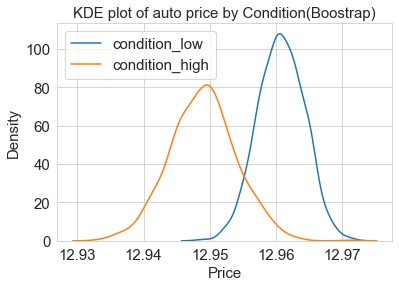

In [41]:
kde_plot2(con_low_b,con_high_b, 'condition_low','condition_high', 'by Condition(Boostrap)')

#### Bayes Model

The 0.950 credible interval is 12.954 to 12.968
The 0.950 credible interval is 12.939 to 12.959


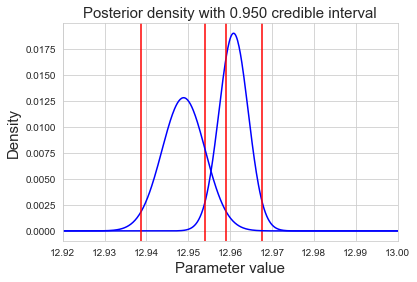

In [42]:
num_samples = 100000
plot_ci(p, post_con_low, num_samples, lower_q=.025, upper_q=.975, x = 12.92, y=13.00)
plot_ci(p, post_con_high, num_samples, lower_q=.025, upper_q=.975, x = 12.92, y=13.00)

### `Grade`

#### Boostrap

In [43]:
test = t_test(gr_low_b, gr_high_b, 0.05)
test

DegFreedom    1321.859870
Difference      -0.405657
Statistic    -1654.445988
PValue           0.000000
Low95CI         -0.406138
High95CI        -0.405176
dtype: float64

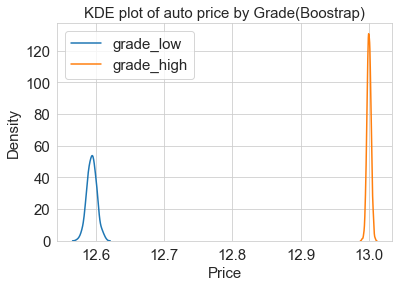

In [44]:
kde_plot2(gr_low_b,gr_high_b, 'grade_low','grade_high', 'by Grade(Boostrap)')

#### Bayes Model

The 0.950 credible interval is 12.580 to 12.608
The 0.950 credible interval is 12.994 to 13.006


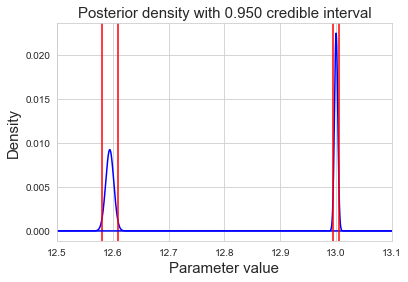

In [45]:
plot_ci(p, post_gr_low, num_samples, lower_q=.025, upper_q=.975, x = 12.5, y = 13.1)
plot_ci(p, post_gr_high, num_samples, lower_q=.025, upper_q=.975, x = 12.5, y = 13.1)

### `Bedrooms`

#### Boostrap

In [46]:
test = t_test(bed_low_b, bed_high_b, 0.05)
test

DegFreedom    1856.331888
Difference      -0.209123
Statistic    -1138.516666
PValue           0.000000
Low95CI         -0.209484
High95CI        -0.208763
dtype: float64

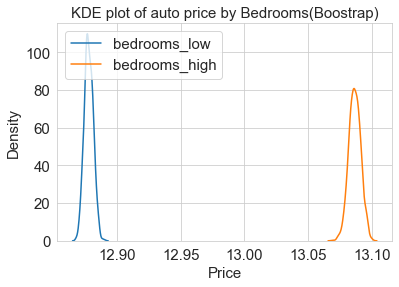

In [47]:
kde_plot2(bed_low_b,bed_high_b, 'bedrooms_low','bedrooms_high', 'by Bedrooms(Boostrap)')

#### Bayes Model

The 0.950 credible interval is 12.871 to 12.885
The 0.950 credible interval is 13.078 to 13.096


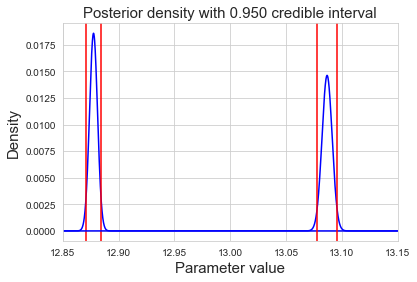

In [48]:
plot_ci(p, post_br_low, num_samples, lower_q=.025, upper_q=.975, x = 12.85, y = 13.15)
plot_ci(p, post_br_high, num_samples, lower_q=.025, upper_q=.975, x = 12.85, y = 13.15)

### `Bathrooms`

#### Bootstrap

In [49]:
f_statistic, p_value = ss.f_oneway(bath_low_b,bath_mid_b,bath_high_b)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 116543.44368042465
P-value = 0.0


In [50]:
#Creating a data frame with the boostraped mean and the categorical value (type of car body)
l = pd.Series('bath_low')
l = pd.concat([l]*len(bath_low_b))

m = pd.Series('bath_mid')
m = pd.concat([m]*len(bath_mid_b))

h = pd.Series('bath_high')
h = pd.concat([h]*len(bath_high_b))

frames = [l, m, h]
result = pd.concat(frames).reset_index()
result = result.iloc[:,1]

frames2 = [bath_low_b,bath_mid_b,bath_high_b]
result2 = pd.concat(frames2).reset_index()
result2 = result2.iloc[:,1]

bath_df = pd.DataFrame({'bathrooms':result,
                     'price_log':result2})

#Tukey HSD Test
Tukey_HSD1 = pairwise_tukeyhsd(bath_df["price_log"], bath_df["bathrooms"])
print(Tukey_HSD1)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1   group2  meandiff p-adj  lower   upper  reject
--------------------------------------------------------
bath_high bath_low  -0.4916 0.001  -0.494 -0.4893   True
bath_high bath_mid  -0.2383 0.001 -0.2407 -0.2359   True
 bath_low bath_mid   0.2534 0.001   0.251  0.2557   True
--------------------------------------------------------


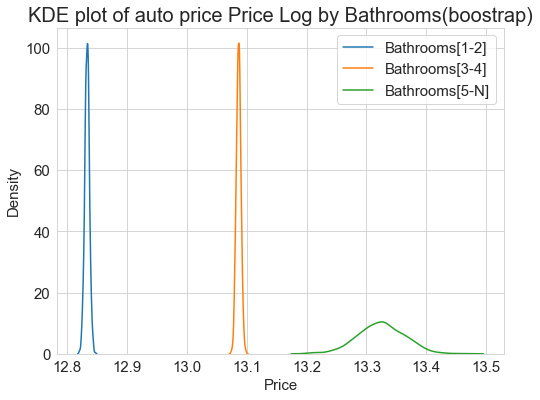

In [51]:
kde_plots(bath_low_b,bath_mid_b,bath_high_b,"Bathrooms[1-2]","Bathrooms[3-4]","Bathrooms[5-N]","Price Log by Bathrooms(boostrap)")

#### Bayes model

The 0.950 credible interval is 12.825 to 12.841
The 0.950 credible interval is 13.079 to 13.094
The 0.950 credible interval is 13.250 to 13.402


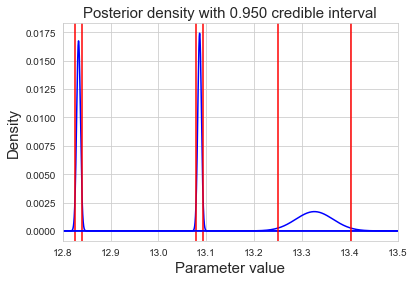

In [52]:
plot_ci(p, post_bath_low, num_samples, lower_q=.025, upper_q=.975, x=12.8, y=13.5)
plot_ci(p, post_bath_mid, num_samples, lower_q=.025, upper_q=.975, x=12.8, y=13.5)
plot_ci(p, post_bath_high, num_samples, lower_q=.025, upper_q=.975, x=12.8, y=13.5)

## Summary of the analysis done above:

- From the analysis it is possible to see that the boostraped mean distribution in all the cases (`condition`, `grade`, `bedrooms` & `bathrooms`) looked pretty similar to the Bayes Model Distribution.


- Even though the distribution for `price` & `price_log` was determined to be **lognorm** after exploring no critical differences were observed after using **normal** distribution as the **prior** distribution for the Bayes Model.


- The only variable where the distributions (values) seem to be overlapping was `condition`. Meaning this was the only case where arguing that the 2 distributions could be similar.


- In all the other cases (`grade`, `bedrooms` &  `bathrooms`) both the boostraping method and the Bayes model concluded that the distributions are statistically different. Practical meaning: These 3 variables by themselves could be used for the prediction of a house's `price` in later analysis.